In [25]:
import pandas as pd
import numpy as np
import pickle
import codecs
import time
from itertools import chain

from sklearn.utils import shuffle
from gensim.models import word2vec

from word_index import get_word_to_int

# CNN 학습에 필요한 데이터 불러오기

# 1. 감정 데이터 불러오기

In [2]:
# 감정 데이터 불러오기
with open("D:\\WorkSpace\\뉴스 데이터\\200319\\comment_with_emo_over0.5.pkl", 'rb') as f:
    emotion_comment_df = pickle.load(f)
    
print("emotion_comment_df: ", emotion_comment_df.shape)
emotion_comment_df.sample(5)

emotion_comment_df:  (366159, 11)


,happy,sad,disgust,angry,surprised,fear,comment_id,comment,comment_token,check,emotion
2142283,0.0,1.0,0.0,0.0,0.0,0.0,C89EA97AE0934C9AA565D5F70F08398D,참담하다~~국당!!!부끄러움은 아는가????,"[참담하다, 국, 부끄러움]",[참담하다],sad
1080915,0.0,0.0,0.0,1.0,0.0,0.0,930C9FDE9FF840B3952A533E2E964A99,김관진 .. 박그네판 이완용 이네. 이 쓰레기.. 어찌 하오라까? ㅆ ㅂ,"[김관진, 박, 판, 이완용, 쓰레기, 어찌]",[쓰레기],angry
776670,0.0,1.0,0.0,0.0,0.0,0.0,C9387D1DF56948ED81D7037D5262FD46,아직어린데 이험한세상 잘헤쳐나가길 너무나 안타깝고 슬프다,"[한세상, 안타깝고, 슬프다]",[슬프다],sad
2324198,0.0,1.0,0.0,0.0,0.0,0.0,619975582381407F84CFBB25F86A02C6,삼가 고인인 명복을 빕니다,"[고인, 명복]","[고인, 명복]",sad
1975106,0.0,0.0,0.0,1.0,0.0,0.0,DFAA2B853F724CE8A77FE3014215F008,식상하고 고루하다. 어린애들 이용해서 돈 벌어서 좋냐? 이 쓰레기 기획사 새끼들아...,"[식상하고, 고루, 애, 이용, 돈, 좋냐, 쓰레기, 기획사, 새끼, 캭, 퇘]","[쓰레기, 새끼]",angry


In [3]:
# Angry, Disgust, Happy, Sad 4가지 감정만 활용
emotion_comment_df.groupby("emotion").size()

emotion
angry        234772
disgust       12806
fear           5636
happy         32693
sad           73216
surprised      7036
dtype: int64

In [4]:
def get_shuffle_df(data, emotion, size):
    emotion_df = data[data["emotion"] == emotion]
    emotion_df = shuffle(emotion_df, random_state = 42).head(size)
    return emotion_df

# 각 감정별로 셔플한 다음 12,000개씩 부여 (Train = 10,000 / Test = 2,000)

hap = get_shuffle_df(emotion_comment_df, "happy", 12000)
sad = get_shuffle_df(emotion_comment_df, "sad", 12000)
dis = get_shuffle_df(emotion_comment_df, "disgust", 12000)
ang = get_shuffle_df(emotion_comment_df, "angry", 12000)

# 데이터 합치기
df_emotion48000 = pd.concat([hap, sad, dis, ang])
df_emotion48000 = shuffle(df_emotion48000)

# 데이터 변환
comment_token_data = df_emotion48000['comment_token'].as_matrix() # as_matrix() = <class 'numpy.ndarray'>

# keras.utils to_categorical은 float형만 됨
# 4가지 감정
label_class = { 'happy': [1,0,0,0],
                'sad': [0,1,0,0],
                'disgust': [0,0,1,0],
                'angry': [0,0,0,1] }

y = np.empty((len(df_emotion48000["emotion"]), 4))

# label_class[v], v must be string
for idx, v in enumerate(df_emotion48000["emotion"]):
    v = str(v)
    y[idx] = label_class[v]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# 2. Word_index 불러오기

In [5]:
# token file 수정
with open('D:\\WorkSpace\\뉴스 데이터\\df_comment0327.pickle', 'rb') as file:
    df_comment = pickle.load(file)
    
print("df_comment: ", df_comment.shape)
df_comment.head(5)

df_comment:  (2393070, 4)


,news_id,comment_id,comment,token
0,20170701070956601,721C65A950C743ECA964282ED055DF5E,픽미가 구준엽 작품이라구? 대단하군 트렌드적중,"[픽미, 구준엽, 작품, 구, ?, 대단하다, 트렌드, 적중]"
1,20170701070956601,A265E5185F4E476E930D459359B3904C,우정과 의리의 대명사 쿵따리,"[우정, 의리, 대명사, 쿵, 따리]"
2,20170701070956601,BC4CC51D1CE845459F3C16245772E4C7,픽미 같은곳에서 벚꽃이 지면! 1년이 지난 지금도 사랑하는 곡들! 들을 때마다 소녀...,"[픽미, 같다, 곳, 벚꽃, 지면, !, 1, 년, 지난, 지금, 사랑, 곡, 들다..."
3,20170701070956601,5FBBAD1A12E34744A360630DB7CE321D,구준엽..정말 감탄나오는 의리있는 친구.. 강원래 사고나고 몇년이 지났건만 강원래를...,"[구준엽, 정말, 감탄, 나오다, 의리, 있다, 친구, 강원래, 사다, 몇, 년, ..."
4,20170701070956601,1A607535BF024C098DBB37E1BE82E1CC,끝까지 친구 챙기는 디제이쿠 멋지다,"[끝, 친구, 챙기다, 디제, 이쿠, 멋지다]"


In [7]:
comment_tokenized_int, n_vocab, word_to_int = get_word_to_int(df_comment["token"])

?(359287) 되다(277243) 있다(271479) 없다(226267) 아니다(207561) 안(193443) 보다(173535) 사람(151362) 같다(135933) 그렇다(129087) 못(125523) 들다(124497) 않다(119280) !(115791) 가다(110580) 
Total Vocab:  231398



In [22]:
# Word embedding model 불러오기
w2v_model = word2vec.Word2Vec.load("D:\\WorkSpace\\뉴스 데이터\\200319\\news_word2vec200_0601.model")

In [9]:
# 지워야 함
comment_tokenized_int

[[189965, 226162, 216325, 75935, 9104, 22195, 218100, 110283],
 [61302, 140508, 208424, 215768, 73728],
 [189965,
  166873,
  25869,
  69605,
  224332,
  52694,
  61146,
  46985,
  3958,
  23150,
  53982,
  22318,
  214475,
  106024,
  185872,
  95078,
  211643,
  159717,
  143386,
  206406,
  17944],
 [226162,
  12405,
  64049,
  170017,
  140508,
  195006,
  21361,
  190128,
  94371,
  76097,
  46985,
  7467,
  70155,
  119923,
  51317,
  225591,
  133876,
  23317,
  68401,
  104551,
  214935,
  177849,
  164006,
  166873,
  75973,
  138671,
  20129,
  72289,
  39971,
  214748,
  82564],
 [127059, 21361, 51363, 192872, 133124, 167890],
 [226162, 214935, 144265, 9363, 170139],
 [189965, 226162, 216325, 85610, 221548, 47048],
 [72587],
 [179786,
  129824,
  16008,
  194631,
  19253,
  206119,
  212470,
  105555,
  53956,
  63068,
  37787,
  145617,
  229177,
  95165,
  78922,
  29811,
  127619,
  158223,
  203286,
  145073,
  65777],
 [94555, 208992, 119923, 73075, 157606, 167794, 1077

In [32]:
# Word embedding Test

# 토큰으로 이루어진 리스트 (문장 X, 단어만으로)
word_index_list = list(chain(*comment_tokenized_int))
print("word_index_list: ", len(word_index_list))

# Word2Vec 사용
empty_count = 0
w2v_embedding_list = []
w2v_embedding_word_is_none_list = [] # word weight 풀어 헤쳐서 모은 것

start_time = time.time()

for tokens in df_comment["token"]:
    w2v_weight_sentence = []
    for token in tokens:
        try:
            word_weight = w2v_model[token] # word embedding model 사용
            w2v_weight_sentence.append(word_weight)
            w2v_embedding_word_is_none_list.append(word_weight)
        except:
            #  단어 없을 때?
            #print("token: ", token)
            w2v_embedding_word_is_none_list.append(None)
            empty_count += 1
            
    w2v_weight_sentence_np = np.array(w2v_weight_sentence)
    
    if w2v_weight_sentence_np.size > 0:
        w2v_embedding_list.append(w2v_weight_sentence_np)
    else:
        w2v_embedding_list.append([])

print("")
print("end time: ", time.time() - start_time)

word_index_list:  31238062


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



end time:  148.12628698349


In [33]:
print("w2v_embedding_list: ", len(w2v_embedding_list))
print("w2v_temp: ", len(w2v_embedding_list))

w2v_embedding_list:  2393070
w2v_temp:  2393070


In [38]:
print("empty_count: ", empty_count)

start_time = time.time()
# embeddings_index = { 단어 : W2V(단어) }
embeddings_index = {}
embeddings_index = dict(zip(word_index_list, w2v_embedding_word_is_none_list)) # 왜 w2v_temp로?
    
# None 갯수 측정
count = 0
i = 0
print("")
print("n_vocab: ", n_vocab)
print("embeddings_index: ", len(embeddings_index))

for word, value in embeddings_index.items():
    if value is None: 
        count += 1
        
print("None count: ", count)

# embedding_matrix 초기화
EMBEDDING_DIM = 200

# word_index = 단어에 index 부여
embedding_matrix = np.zeros((len(word_to_int) , EMBEDDING_DIM))
print()
print("embedding_matrix.shape: ", embedding_matrix.shape)

for word, i in word_to_int.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("")
print("end time: ", time.time() - start_time)

empty_count:  11422987

n_vocab:  231398
embeddings_index:  231398
None count:  211062

embedding_matrix.shape:  (231398, 200)

end time:  3.342024803161621


In [15]:
tokens_data_np = np.array(tokens_data)

In [18]:
tokens_data_np[np.isnan(tokens_data_np)]

array([], dtype=int32)

In [19]:
None in tokens_data_np

False

In [21]:
word_index_list

[189965,
 226162,
 216325,
 75935,
 9104,
 22195,
 218100,
 110283,
 61302,
 140508,
 208424,
 215768,
 73728,
 189965,
 166873,
 25869,
 69605,
 224332,
 52694,
 61146,
 46985,
 3958,
 23150,
 53982,
 22318,
 214475,
 106024,
 185872,
 95078,
 211643,
 159717,
 143386,
 206406,
 17944,
 226162,
 12405,
 64049,
 170017,
 140508,
 195006,
 21361,
 190128,
 94371,
 76097,
 46985,
 7467,
 70155,
 119923,
 51317,
 225591,
 133876,
 23317,
 68401,
 104551,
 214935,
 177849,
 164006,
 166873,
 75973,
 138671,
 20129,
 72289,
 39971,
 214748,
 82564,
 127059,
 21361,
 51363,
 192872,
 133124,
 167890,
 226162,
 214935,
 144265,
 9363,
 170139,
 189965,
 226162,
 216325,
 85610,
 221548,
 47048,
 72587,
 179786,
 129824,
 16008,
 194631,
 19253,
 206119,
 212470,
 105555,
 53956,
 63068,
 37787,
 145617,
 229177,
 95165,
 78922,
 29811,
 127619,
 158223,
 203286,
 145073,
 65777,
 94555,
 208992,
 119923,
 73075,
 157606,
 167794,
 107772,
 227950,
 170139,
 189965,
 16106,
 104814,
 55136,
 2

In [ ]:
# word_index
with open('D:\\WorkSpace\\뉴스 데이터\\word_index.pickle', 'rb') as file:
    big_to_int = pickle.load(file)

print (type(big_to_int))
print (len(big_to_int))
word_index = big_to_int # word_index type dictionary

i = 1
for key in word_index.keys():
    print (key, ":", word_index[key])
    i += 1
    if (i > 10): break
print ("")

In [1]:
import pandas as pd
import numpy as np
import pickle
import codecs
from gensim.models import word2vec
from konlpy.tag import Twitter
from sklearn.model_selection import train_test_split

import keras
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def tokenizer_comment(comment):
    from konlpy.tag import Twitter
    twitter = Twitter()
    i = 0
    malist = twitter.pos(comment,stem=True)
    r = []

    # 불용어 추가
    stopwords = ['하다', ',', '들', '이', '..', '.', '것', '다', '이다', '~', '그', '그녀', '저', '...', '"', '~~']
    
    remove_tag = ['Determiner', 'Josa', 'Eomi', 'PreEomi', 'URL', 'Email', 'Hashtag', 'Alpha',
                  'ScreenName', 'KoreanParticle', 'Foreign', 'Cashtag']
    
    try:
        for word in malist:
            # 어미/조사/구두점/ㅋㅋ^^ㅎㅎ/음표살림/Alphabet/부사는 대상에서 제외            
            if not word[1] in remove_tag:
                if not word[0] in r:
                    if not word[0] in stopwords:
                        # 숫자, 특수문자 제거.
                        r.append(word[0])
        return r

    except Exception as e:
        print (e)
    
def print15(a):
    print ("15 line")
    i = 0
    for item in a:
        print (item)
        i += 1
        if i > 15: break

C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# 감정 데이터 불러오기

In [2]:
with open('D:\\WorkSpace\\뉴스 데이터\\emotion433942_0312.pickle', 'rb') as file:
    comment_df = pickle.load(file)

pd.set_option('display.precision', 2)    
print (type(comment_df))
print (len(comment_df))
print (comment_df.head(5))
print ("")

# word_index
with open('D:\\WorkSpace\\뉴스 데이터\\word_index.pickle', 'rb') as file:
    big_to_int = pickle.load(file)

print (type(big_to_int))
print (len(big_to_int))
word_index = big_to_int # word_index type dictionary

i = 1
for key in word_index.keys():
    print (key, ":", word_index[key])
    i += 1
    if (i > 10): break
print ("")

# emotion dataframe 만들기
df_emotion6 = pd.DataFrame(data={'tokened_comment' : comment_df['token'],
                                'label' : comment_df['emotion']},
                                 columns=['tokened_comment','label'])

df_emotion6 = df_emotion6.reset_index()
print(df_emotion6.head(5))
print("")

# happy, sad, disgust, surprised, fear, angry

print('기쁨: ',len(df_emotion6[df_emotion6.label ==  1]))
print('슬픔: ',len(df_emotion6[df_emotion6.label ==  2]))
print('혐오: ',len(df_emotion6[df_emotion6.label ==  3]))
print('놀람: ',len(df_emotion6[df_emotion6.label ==  4]))
print('공포: ',len(df_emotion6[df_emotion6.label ==  5]))
print('분노: ',len(df_emotion6[df_emotion6.label ==  6]))

# 각 감정별로 셔플한 다음 만 개씩 부여
from sklearn.utils import shuffle

hap = df_emotion6[df_emotion6.label ==  1]
hap = shuffle(hap).head(10000)
sad = df_emotion6[df_emotion6.label ==  2]
sad = shuffle(sad).head(10000)
dis = df_emotion6[df_emotion6.label ==  3]
dis = shuffle(dis).head(10000)
sur = df_emotion6[df_emotion6.label ==  4]
sur = shuffle(sur).head(10000)
fea = df_emotion6[df_emotion6.label ==  5]
fea = shuffle(fea).head(10000)
ang = df_emotion6[df_emotion6.label ==  6]
ang = shuffle(ang).head(10000)

## 최소 개수 fear : 11676개 

# 데이터 합치기
df_emotion60000 = pd.concat([hap,sad,dis,sur,fea,ang])
df_emotion60000 = shuffle(df_emotion60000)

# 데이터 변환
comment_token_data = df_emotion60000['tokened_comment'].as_matrix() # as_matrix() = <class 'numpy.ndarray'>

# 6가지 감정
label_class = { '1': [1,0,0,0,0,0],
                '2': [0,1,0,0,0,0],
                '3': [0,0,1,0,0,0],
                '4': [0,0,0,1,0,0],
                '5': [0,0,0,0,1,0],
                '6': [0,0,0,0,0,1]}

y = np.empty((len(df_emotion60000["label"]), 6))

# label_class[v], v must be string
for i,v in enumerate(df_emotion60000["label"]):
    v = str(v)
    y[i] = label_class[v]
print ("")
print (df_emotion60000.head(5))

<class 'pandas.core.frame.DataFrame'>
433942
     happy  sad  disgust  surprised  fear  angry  total  \
48   100.0  0.0      0.0        0.0   0.0    0.0      1   
58   100.0  0.0      0.0        0.0   0.0    0.0      1   
79   100.0  0.0      0.0        0.0   0.0    0.0      1   
83   100.0  0.0      0.0        0.0   0.0    0.0      1   
110  100.0  0.0      0.0        0.0   0.0    0.0      1   

                                                 token  emotion  
48   [아래, 댓글, 보다, 어떻다, 분, 가정폭력, 포함, 어렵다, 환경, 사람, 멘탈...        1  
58   [가정, 폭력, 환경, 자라다, 자녀, 피해자, 하지만, 결혼, 상대로, 직원, 피...        1  
79                                       [개, 로써, 훌륭하다]        1  
83     [동네, 양, 아치, 지다, 들다, 끼리, 허리, 굽히다, 형님, 똑, 같다, 보임]        1  
110                                      [순장, 시키다, 감동]        1  

<class 'dict'>
184313
샛기들 : 169271
하니 : 145828
타율 : 132670
돈쳐발랐겠 : 85666
바다뱀 : 22537
지꼬올리 : 88273
누기 : 64438
빨겡이들짓 : 84101
표전석 : 8964
알라일 : 155582

   index                                    tokened_com

# extra data

In [3]:
with open('D:\\WorkSpace\\뉴스 데이터\\extra_total3_X.pickle', 'rb') as file:
    df_extra_total_X = pickle.load(file)

print ("df_extra_total_X")
print (type(df_extra_total_X))
print (df_extra_total_X.shape)
print (df_extra_total_X.head(5))

with open('D:\\WorkSpace\\뉴스 데이터\\extra_total3_y.pickle', 'rb') as file:
    df_extra_total_y = pickle.load(file)

print ("")
print ("df_extra_total_y")
print (type(df_extra_total_y))
print (len(df_extra_total_y))
print15 (df_extra_total_y)

# shuffle extra
df_extra_total_y12 = pd.DataFrame({"label" : df_extra_total_y})
df_extra_total_y12
df_extra_temp = pd.concat([df_extra_total_X, df_extra_total_y12], axis = 1)
df_extra_temp = shuffle(df_extra_temp) #shuffle
print ("")
print (df_extra_temp.head(10))

# extra x type 변환
extra_x = df_extra_temp["token"].as_matrix()
print ("")
print ("len, extra_x: ", len(extra_x))

# 기존 데이터 X + 추가데이터 X
total_token_data = np.concatenate((comment_token_data, extra_x))
print ("")
print ("len, total_token_data", len(total_token_data))
print (type(total_token_data))
print15 (total_token_data)

# extra y type 변환
extra_y = df_extra_temp["label"]
li_extra_y = list(extra_y)
print ("")
print15(li_extra_y)

# 기존 데이터 y + 추가 데이터 y
total_y = np.concatenate((y, li_extra_y))
print ("")
print (len(total_y))
print (type(total_y))
print15 (total_y)

df_extra_total_X
<class 'pandas.core.frame.DataFrame'>
(26515, 3)
                                               token  \
0  [댓글, 점점, 기괴, 괴팍, 차다, 못, 되다, 인간, 습성, 그대로, 드러내다,...   
1  [인간, 쓰레기, 젠, 이렇다, 더, 이상, 기회, 따뜻하다, 시선, 아깝다, 진짜...   
2                     [돈, 몇, 만원, 아깝다, 아니다, 차다, 한심하다]   
3  [드라마, 재밌다, 배우, 모두, 제, 옷, 입다, 듯, 자연, 연기, 잘하다, 무...   
4  [연기, 잘하다, 보다, 불쾌, 드라마, 온통, 바람, 피다, 사람, 없다, 청소년...   

                                             comment  \
0  댓글들이 점점... 기괴하고 괴팍하고 참 못된 인간의 습성을 그대로 드러낸다 심지어...   
1  인간 쓰레기네  이젠 이런 인간들에겐 더 이상 기회도 따뜻한 시선도 아깝다  진짜 ...   
2                        돈 몇만원이 아까운건 아닐거고... 참 한심하다.   
3  이 드라마 재밌고, 배우들이 모두 제 옷 입은 듯 자연스럽게 연기 잘하고,  무엇보...   
4  연기들은 잘하는데 볼수록 불쾌한 드라마 온통 바람피는  사람들밖에 없네ㆍ 청소년들 ...   

                         comment_id  
0  AD1CE791AAED4300A073BF0EBF980236  
1  7842731E846740A79E01828AF8C57C4D  
2  7BD559216FD94FE48FB9EF6418F85B2A  
3  5C07DCF03A35428CB7B786E364F2B5C0  
4  DBB553A8EDD44D398F95A1D67EEB35B2  

df_extra_total_y
<class 'list'>

# Preparing the embedding layer

In [4]:
def comment_int(token_data):
    unique_comment_tokenized = [list(i) for i in set(tuple(i) for i in token_data)]
    word_dic = {}
    
    # word count
    for words in unique_comment_tokenized:
        for word in words:
            if not(word in word_dic):
                word_dic[word] = 0
            word_dic[word] += 1

    keys = sorted(word_dic.items(), key = lambda x:x[1], reverse = True)
    for word, count in keys[:50]:
        print("{0}({1}) ". format(word, count), end = "")
    
    # [] 없애주는 코드
    from itertools import chain
    words = set(chain(*unique_comment_tokenized))
    
    # 큰 데이터로 mapping
    global big_to_int
    temp = big_to_int
    
    n_vocab = len(temp)
    print ("")
    print ("Total Vocab: ", n_vocab)
    print ("")
    comment_tokenized_int = []

    for comment in token_data:
        item_int = []
        for item in comment:
            item_int.append(temp.get(item))
        comment_tokenized_int.append(item_int)
    
    return comment_tokenized_int, n_vocab

In [5]:
token_int, n_vocab = comment_int(total_token_data)

?(17123) 되다(16739) 있다(16196) 없다(13436) 아니다(11387) 안(10782) 보다(10105) 사람(9627) 못(9392) 않다(8270) 같다(8063) 들다(7898) 그렇다(7738) 무섭다(6950) 적(6820) 이렇다(6518) 말(6271) 가다(6196) 받다(6099) 더(6079) 좋다(5973) 놈(5970) 국민(5964) !(5573) 생각(5430) 때(5301) 먹다(4898) 왜(4795) 나라(4780) 더럽다(4769) 알다(4525) ....(4504) 많다(4436) 정말(4321) 지다(4237) 싫다(4236) 일(4211) 쓰다(4202) 나오다(4156) 자(4136) 년(3998) 뭐(3989) 시키다(3965) 돈(3954) 좀(3941) 차다(3937) 개(3891) 너무(3810) 인간(3792) 살다(3776) 
Total Vocab:  184313



In [6]:
# Word2vec 모델 불러오기

w2v_model = word2vec.Word2Vec.load("D:\\WorkSpace\\뉴스 데이터\\news_word2vec200_0305.model")

In [8]:
token_int

NameError: name 'token_int' is not defined

In [7]:
# 줄을 풀어 헤쳐서 저장.
tokens_data = []
for line in total_token_data:
    for token in line:
        tokens_data.append(token)

print ("")
print (type(tokens_data))
print (len(tokens_data))
print15 (tokens_data)

print ("")
print ("n_vocab: ", n_vocab)
print ("length: ", len(token_int))
print15(token_int)

# None 제거
comment_tokenized_int2 = token_int.copy()
print ("")
print ("len, comment_tokenized_int2: ", len(comment_tokenized_int2))
print15(comment_tokenized_int2)

times = 0
for i in range(0, 100):
    p_count = 0
    i = 0
    times += 1
    temp = []
    
    for line in comment_tokenized_int2:
        j = 0
        for word in line:
            if word == None:
                # print ("i : {0}, j: {1}".format(i,j))
                temp = comment_tokenized_int2[i].pop(j)
                p_count += 1
            j += 1
        i += 1
    print ("p_count: ", p_count)
    print ("times: ", times)
    
    if p_count == 0: break

print ("")    
print ("p_count: ", p_count)
print (len(comment_tokenized_int2))
print15(comment_tokenized_int2)

# 문장 별로 아니고 풀어 헤쳐서 모은 것.
all_word_index = []

for tokens in comment_tokenized_int2:
    for token in tokens:
        all_word_index.append(token)
    
print (len(all_word_index))
print (type(all_word_index))
print15(all_word_index)

# Word2Vec 사용
empty = 0
w2v_embedding = []
w2v_temp = [] # 문장 별로 아니고 풀어 헤쳐서 모은 것. 

# Word2vec embedding
for tokens in total_token_data:
    w2v_line = []
    for token in tokens:
        try:
            temp = w2v_model[token]
            w2v_line.append(temp)
            w2v_temp.append(temp)            
        except:
            # 단어 없을 때 None 추가
            w2v_temp.append(None)
            #w2v_line.append([])
            empty += 1
    
    w2v_line = np.array(w2v_line)
    
    if w2v_line.size > 0:
        w2v_embedding.append(w2v_line)
        #print(w2v_line.mean(axis=1))
        #w2v_embedding_mean.append(w2v_line.mean(axis=0))
    else:
        #w2v_embedding_mean.append([])
        w2v_embedding.append([])

print ("")
print ("len: ",  len(total_token_data))
print ("empty: ", empty)

print ("")
print ("check word embedding")
i = 0
for a in w2v_embedding:
    i += 1
    print (a)
    print ("")
    if i > 3: break
        
print ("")
print ("w2v_temp")
print (type(w2v_temp))
print (len(w2v_temp))
print15(w2v_temp)

# embeddings_index = { 단어 : W2V(단어) }
embeddings_index = {}
embeddings_index = dict(zip(tokens_data, w2v_temp))
i = 0

print ("")
for word, value in embeddings_index.items():
    print (word, value)
    print ("")
    i += 1
    if i > 3: break
    
# None 갯수 측정
count = 0
i = 0
print ("")
print("embeddings_index: ", len(embeddings_index))

for word, value in embeddings_index.items():
    if value is None: 
        count += 1
        
print (count)

# embedding_matrix 초기화
EMBEDDING_DIM = 200

# word_index = 단어에 index 부여
embedding_matrix = np.zeros((len(word_index) , EMBEDDING_DIM))
print ("embedding_matrix.shape: ", embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print ("")
print ("embedding_matrix.shape: ", embedding_matrix.shape)
print (embedding_matrix.shape)
print15(embedding_matrix)



<class 'list'>
1910994
15 line
여론
갈리
길
10
년
12
거지
피스
터
피자
광고
마르다
볼때
역겹다
여기
모델

n_vocab:  184313
length:  86515
15 line
[74623, 100745, 14891, 126653, 38857, 168404, 160834]
[1633, 158339, 172289, 33814, 181534, 124613, 142246, 40544, 71392, 67507, 57169, 126713]
[101373, 117826, 62148, 78480, 85485, 38857, 625, 158896, 146249, 162857, 95778, 150812, 76914, 92163, 36539, 105123, 104589, 180205, 145000, 35034, 123860, 117163, 146167, 91063, 3833, 39580, 27160, 73166, 164775, 102078, 89920, 55636, 76708, 37551, 89158, 105642, 64155, 96564, 73928, 54510, 6085, 159772, 130939, 67928, 170905, 42042, 5206, 84013, 105128, 168765, 63923, 50014, 68991, 85054, 142409, 47986, 43154, 63932, 166457, 123505, 104913, 172763, 91832]
[67014, 106673, 7562, 5040, 182311, 162708, 54247, 7463, 126417, 150919, 39367, 30118, 50844, 123011, 44273, 112877, 160396, 32517, 126713]
[37376, 49182, 76710, 36584, 127330, 170935, 34417, 129754, 70581, 93385]
[67803, 87928, 52914, 167915, 49918, 107448, 143340, 172763

C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:70: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



len:  86515
empty:  20146

check word embedding
[[ 1.37957096  0.68059015  0.62948328 ...,  1.06743717 -0.35200045
  -0.57561111]
 [-0.00518497  0.63357753  0.03639176 ..., -0.40876311  0.20965299
   0.14542873]
 [ 0.13740635 -0.36654025  0.62696666 ..., -0.6177603   0.14773583
   1.58670294]
 ..., 
 [-1.69349122 -3.55389619 -3.99432445 ..., -0.38105834 -2.17291307
   2.32846785]
 [ 3.16682386  0.93318182  0.12428141 ...,  0.42578906  1.38009775
  -0.74758321]
 [ 0.36870211 -2.24567151  0.34681916 ...,  0.22513165 -0.84155923
   0.41992477]]

[[ -1.02273956e-01   1.73525494e-02  -6.63933810e-04 ...,  -1.16758756e-01
   -8.24992433e-02  -4.87144245e-03]
 [ -5.27692258e-01  -7.37723932e-02   5.70445895e-01 ...,  -5.68476260e-01
    1.42095065e+00   6.62798762e-01]
 [ -1.53574765e+00   4.51861858e-01   1.29301322e+00 ...,   3.34667623e-01
   -5.28781235e-01  -1.49130416e+00]
 ..., 
 [  1.42853916e+00  -8.22285116e-01  -9.87681568e-01 ...,   6.60032690e-01
    3.15277934e-01   3.07939887e

(184313, 200)
15 line
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 1.02015495  1.25837755  0.63588297 -1.3872453   1.41176665 -1.01945055
  0.40139034 -0.02034091 -2.61288786 -1.75433886 -0.2204451  -0.92614269
  0.49705708  0.225

In [8]:
def pad_sequence(data, length):
    from keras.preprocessing import sequence
    from keras.layers import Dense, Embedding, Flatten

    # 문장 길이 맞추기
    X_int = sequence.pad_sequences((data) , maxlen=length)

    # 훈련셋과 시험셋으로 나눔
    X_train, X_test, y_train, y_test = train_test_split(X_int, total_y, test_size=0.2, random_state=1)
    print("X_train: %d, X_test: %d, y_train: %d, y_test: %d" % (X_train.shape[0], X_test.shape[0], 
                                                                y_train.shape[0], y_test.shape[0]))
    print ("")
    print (X_train.shape)
    print (X_train)
    
    print ("")
    print (y_train.shape)
    print (y_train)
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = pad_sequence(comment_tokenized_int2, 20)

X_train: 69212, X_test: 17303, y_train: 69212, y_test: 17303

(69212, 20)
[[ 37687 116310  94870 ...,  70785  37376 179647]
 [     0      0      0 ..., 144402  29364 128911]
 [     0      0      0 ...,   1920  44219  56040]
 ..., 
 [     0      0      0 ...,   6377  38857 115293]
 [126713  30831 170106 ..., 159363 167625 116412]
 [174036 152156 158908 ...,  13913  35846  17858]]

(69212, 6)
[[ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  1.]]


# CNN

In [10]:
from keras.layers import GlobalAveragePooling1D
from keras.layers import Conv2D
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11675477029079014330
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6772842168
locality {
  bus_id: 1
}
incarnation: 515286277399956038
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [11]:
def cnn_model(dropout):
    import keras.backend.tensorflow_backend as K
    from keras.layers import Embedding
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv = Sequential()        

        EMBEDDING_DIM = 200
        MAX_SEQUENCE_LENGTH = 20

        model_Conv.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )

        model_Conv.add(Conv1D(256,
                            3,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv.add(Dropout(dropout))

        model_Conv.add(GlobalMaxPooling1D())
        
        model_Conv.add(Dense(128, activation='relu'))
        model_Conv.add(Dropout(dropout))

        model_Conv.add(Dense(32, activation='relu'))
        model_Conv.add(Dropout(dropout))

        model_Conv.add(Dense(6, activation='softmax'))
 
        model_Conv.compile(
            loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy']) 

        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model = model_Conv.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        import matplotlib
        import matplotlib.pyplot as plt

        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model.history['acc'], 'b', label = 'train acc')
        acc_ax.plot(conv_model.history['val_acc'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv

In [12]:
def cnn_model2(dropout):
    import keras.backend.tensorflow_backend as K
    from keras.layers import Embedding
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv2 = Sequential()        

        EMBEDDING_DIM = 200
        MAX_SEQUENCE_LENGTH = 20

        model_Conv2.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(GlobalMaxPooling1D())
        
        model_Conv2.add(Dense(256, activation='relu'))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Dense(64, activation='relu'))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(Dense(6, activation='softmax'))
 
        model_Conv2.compile(
            loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy']) 
        
        # model_Conv2.summary()
        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model2 = model_Conv2.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv2.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        import matplotlib
        import matplotlib.pyplot as plt

        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model2.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model2.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model2.history['acc'], 'b', label = 'train acc')
        acc_ax.plot(conv_model2.history['val_acc'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv2

In [20]:
def cnn_model3(dropout):
    import keras.backend.tensorflow_backend as K
    from keras.layers import Embedding
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv3 = Sequential()        

        EMBEDDING_DIM = 200
        MAX_SEQUENCE_LENGTH = 20

        model_Conv3.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )
        # 6 Conv1D layer
        model_Conv3.add(Conv1D(512,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(512,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(512,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))

        model_Conv3.add(GlobalMaxPooling1D())
        
#         model_Conv3.add(Dense(1024, activation='relu'))
#         model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Dense(256, activation='relu'))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Dense(64, activation='relu'))
        model_Conv3.add(Dropout(dropout))

        model_Conv3.add(Dense(6, activation='softmax'))
 
        model_Conv3.compile(
            loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy']) 
        
        # model_Conv2.summary()
        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model3 = model_Conv3.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv3.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        import matplotlib
        import matplotlib.pyplot as plt

        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model3.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model3.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model3.history['acc'], 'b', label = 'train acc')
        acc_ax.plot(conv_model3.history['val_acc'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv3

# Test

In [ ]:
cnn = cnn_model(0.7)

In [ ]:
cnn2 = cnn_model2(0.6)

In [ ]:
# 0.7부터 이상해짐
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]
 0.6, 0.7, 0.8, 0.9

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        cnn2 = cnn_model2(d)
#     #cnn = cnn_model(d)

In [ ]:
# 0.7부터 이상해짐
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        cnn2 = cnn_model2(d)
#     #cnn = cnn_model(d)

In [ ]:
dropout = [0.6, 0.7, 0.8, 0.9]

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        cnn2 = cnn_model2(d)
#     #cnn = cnn_model(d)

Train on 62290 samples, validate on 6922 samples
Epoch 1/200
62290/62290 [==============================] - 8s 133us/step - loss: 2.3960 - acc: 0.2467 - val_loss: 2.3737 - val_acc: 0.5302
Epoch 2/200
62290/62290 [==============================] - 7s 110us/step - loss: 2.0675 - acc: 0.5105 - val_loss: 1.9298 - val_acc: 0.5462
Epoch 3/200
62290/62290 [==============================] - 7s 109us/step - loss: 1.9021 - acc: 0.5231 - val_loss: 1.8610 - val_acc: 0.5816
Epoch 4/200
62290/62290 [==============================] - 7s 110us/step - loss: 1.8145 - acc: 0.5642 - val_loss: 1.6886 - val_acc: 0.6647
Epoch 5/200
62290/62290 [==============================] - 7s 108us/step - loss: 1.6848 - acc: 0.6283 - val_loss: 1.6150 - val_acc: 0.6153
Epoch 6/200
62290/62290 [==============================] - 7s 108us/step - loss: 1.6070 - acc: 0.6568 - val_loss: 1.5201 - val_acc: 0.7765
Epoch 7/200
62290/62290 [==============================] - 7s 108us/step - loss: 1.4656 - acc: 0.7402 - val_loss: 1.3

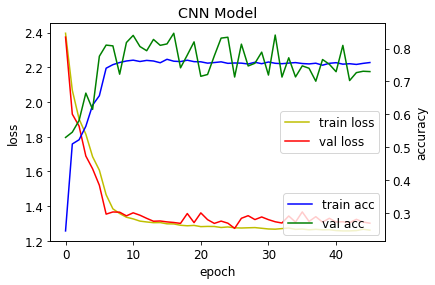

In [15]:
cnn3 = cnn_model3(0.4)

Train on 62290 samples, validate on 6922 samples
Epoch 1/200
62290/62290 [==============================] - 8s 127us/step - loss: 2.5875 - acc: 0.1725 - val_loss: 2.4523 - val_acc: 0.3116
Epoch 2/200
62290/62290 [==============================] - 7s 110us/step - loss: 2.3327 - acc: 0.2457 - val_loss: 2.5145 - val_acc: 0.2044
Epoch 3/200
62290/62290 [==============================] - 7s 114us/step - loss: 2.1974 - acc: 0.2904 - val_loss: 2.4457 - val_acc: 0.2800
Epoch 4/200
62290/62290 [==============================] - 8s 127us/step - loss: 2.1359 - acc: 0.2974 - val_loss: 2.3259 - val_acc: 0.3167
Epoch 5/200
62290/62290 [==============================] - 7s 109us/step - loss: 2.1005 - acc: 0.3029 - val_loss: 2.1859 - val_acc: 0.3279
Epoch 6/200
62290/62290 [==============================] - 7s 109us/step - loss: 2.0733 - acc: 0.3064 - val_loss: 2.0921 - val_acc: 0.3404
Epoch 7/200
62290/62290 [==============================] - 7s 110us/step - loss: 2.0487 - acc: 0.3200 - val_loss: 2.0

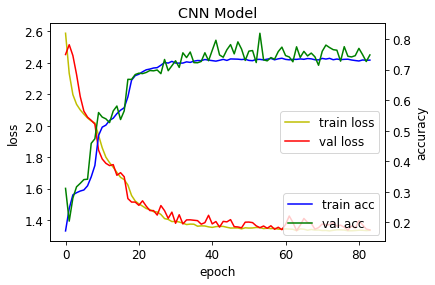

In [16]:
cnn3 = cnn_model3(0.5)

In [21]:
# 0.7부터 이상해짐
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        cnn3 = cnn_model3(d)
#     #cnn = cnn_model(d)

Check 1, dropout: 0.1


ResourceExhaustedError: OOM when allocating tensor with shape[184313,200]
	 [[Node: embedding_37/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_37/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_37/embeddings, embedding_37/random_uniform)]]

Caused by op 'embedding_37/embeddings/Assign', defined at:
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-bcb95a2747cc>", line 7, in <module>
    cnn3 = cnn_model3(d)
  File "<ipython-input-20-3541b225d61a>", line 15, in cnn_model3
    trainable = False) )
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\models.py", line 464, in add
    layer(x)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\engine\topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\layers\embeddings.py", line 101, in build
    dtype=self.dtype)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\engine\topology.py", line 400, in add_weight
    constraint=constraint)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 380, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __init__
    constraint=constraint)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 346, in _init_from_args
    validate_shape=validate_shape).op
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 56, in assign
    use_locking=use_locking, name=name)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[184313,200]
	 [[Node: embedding_37/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_37/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_37/embeddings, embedding_37/random_uniform)]]


Check 1, dropout: 0.6
Train on 62290 samples, validate on 6922 samples
Epoch 1/200
62290/62290 [==============================] - 10s 163us/step - loss: 2.8625 - acc: 0.1723 - val_loss: 2.5952 - val_acc: 0.1167
Epoch 2/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5706 - acc: 0.1491 - val_loss: 2.5808 - val_acc: 0.1167
Epoch 3/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5414 - acc: 0.1322 - val_loss: 2.5855 - val_acc: 0.1167
Epoch 4/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.4358 - acc: 0.1890 - val_loss: 2.5918 - val_acc: 0.1484
Epoch 5/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.3280 - acc: 0.2300 - val_loss: 2.8626 - val_acc: 0.1494
Epoch 6/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.2461 - acc: 0.2629 - val_loss: 2.5927 - val_acc: 0.1822
Epoch 7/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.1931 - acc:

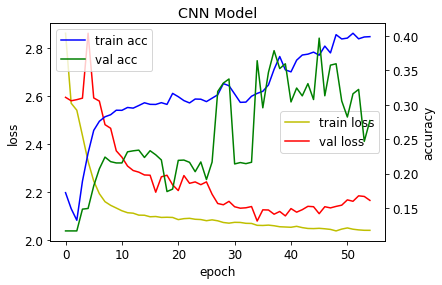

Check 2, dropout: 0.6
Train on 62290 samples, validate on 6922 samples
Epoch 1/200
62290/62290 [==============================] - 10s 165us/step - loss: 2.8321 - acc: 0.1857 - val_loss: 2.5940 - val_acc: 0.1167
Epoch 2/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5678 - acc: 0.1541 - val_loss: 2.5807 - val_acc: 0.1167
Epoch 3/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5344 - acc: 0.1352 - val_loss: 2.5640 - val_acc: 0.1167
Epoch 4/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.4180 - acc: 0.1972 - val_loss: 2.6082 - val_acc: 0.3113
Epoch 5/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.3478 - acc: 0.2031 - val_loss: 2.6887 - val_acc: 0.1205
Epoch 6/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.2773 - acc: 0.2483 - val_loss: 2.8098 - val_acc: 0.1227
Epoch 7/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.2175 - acc:

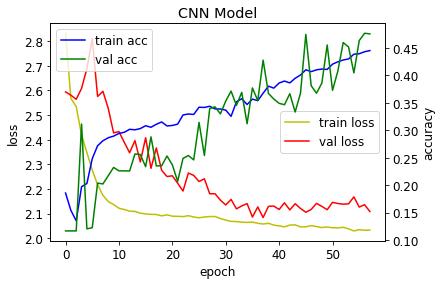

Check 3, dropout: 0.6
Train on 62290 samples, validate on 6922 samples
Epoch 1/200
62290/62290 [==============================] - 10s 166us/step - loss: 2.8153 - acc: 0.1823 - val_loss: 2.5975 - val_acc: 0.1167
Epoch 2/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5706 - acc: 0.1587 - val_loss: 2.5812 - val_acc: 0.1167
Epoch 3/200
62290/62290 [==============================] - 7s 118us/step - loss: 2.5357 - acc: 0.1390 - val_loss: 2.5706 - val_acc: 0.1167
Epoch 4/200
62290/62290 [==============================] - 7s 119us/step - loss: 2.4197 - acc: 0.2203 - val_loss: 2.5436 - val_acc: 0.2689
Epoch 5/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.3642 - acc: 0.2107 - val_loss: 2.5279 - val_acc: 0.1167
Epoch 6/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.3182 - acc: 0.1996 - val_loss: 2.5768 - val_acc: 0.1167
Epoch 7/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.2844 - acc:

62290/62290 [==============================] - 7s 111us/step - loss: 1.7413 - acc: 0.5649 - val_loss: 1.7538 - val_acc: 0.6368
Epoch 60/200
62290/62290 [==============================] - 7s 112us/step - loss: 1.7395 - acc: 0.5678 - val_loss: 1.8124 - val_acc: 0.6297
Epoch 61/200
62290/62290 [==============================] - 7s 111us/step - loss: 1.7338 - acc: 0.5671 - val_loss: 1.7366 - val_acc: 0.6201
Epoch 62/200
62290/62290 [==============================] - 7s 111us/step - loss: 1.7336 - acc: 0.5612 - val_loss: 1.7402 - val_acc: 0.6326
Epoch 63/200
62290/62290 [==============================] - 7s 112us/step - loss: 1.7300 - acc: 0.5633 - val_loss: 1.7375 - val_acc: 0.6323
Epoch 64/200
62290/62290 [==============================] - 7s 111us/step - loss: 1.7260 - acc: 0.5666 - val_loss: 1.7839 - val_acc: 0.6406
Epoch 65/200
62290/62290 [==============================] - 7s 111us/step - loss: 1.7267 - acc: 0.5686 - val_loss: 1.7339 - val_acc: 0.6218
Epoch 66/200
62290/62290 [=======

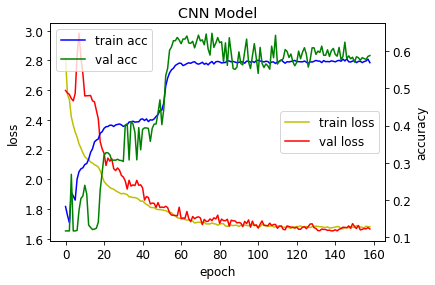

Check 1, dropout: 0.7
Train on 62290 samples, validate on 6922 samples
Epoch 1/200
62290/62290 [==============================] - 10s 167us/step - loss: 12.0556 - acc: 0.2074 - val_loss: 2.6237 - val_acc: 0.1167
Epoch 2/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5918 - acc: 0.1628 - val_loss: 2.5678 - val_acc: 0.1167
Epoch 3/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5706 - acc: 0.1405 - val_loss: 2.5576 - val_acc: 0.1167
Epoch 4/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5653 - acc: 0.1320 - val_loss: 2.5548 - val_acc: 0.1167
Epoch 5/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5630 - acc: 0.1254 - val_loss: 2.5530 - val_acc: 0.1167
Epoch 6/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5620 - acc: 0.1219 - val_loss: 2.5525 - val_acc: 0.1167
Epoch 7/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5598 - acc

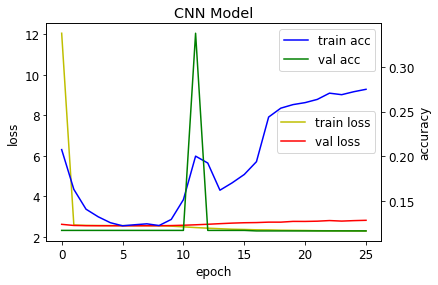

Check 2, dropout: 0.7
Train on 62290 samples, validate on 6922 samples
Epoch 1/200
62290/62290 [==============================] - 11s 169us/step - loss: 9.9043 - acc: 0.1972 - val_loss: 2.6085 - val_acc: 0.1881
Epoch 2/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5882 - acc: 0.1853 - val_loss: 2.5629 - val_acc: 0.1167
Epoch 3/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5713 - acc: 0.1478 - val_loss: 2.5556 - val_acc: 0.1167
Epoch 4/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5656 - acc: 0.1294 - val_loss: 2.5541 - val_acc: 0.1167
Epoch 5/200
62290/62290 [==============================] - 7s 112us/step - loss: 2.5632 - acc: 0.1261 - val_loss: 2.5533 - val_acc: 0.1167
Epoch 6/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5620 - acc: 0.1233 - val_loss: 2.5527 - val_acc: 0.1167
Epoch 7/200
62290/62290 [==============================] - 7s 111us/step - loss: 2.5601 - acc:

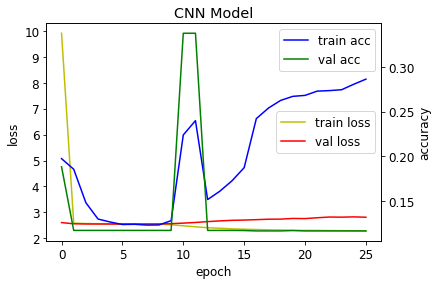

Check 3, dropout: 0.7
Train on 62290 samples, validate on 6922 samples
Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[256,20,512]
	 [[Node: dropout_319/cond/dropout/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=5039598, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dropout_319/cond/dropout/Shape)]]
	 [[Node: metrics_35/acc/Mean/_8045 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1990_metrics_35/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'dropout_319/cond/dropout/random_uniform/RandomUniform', defined at:
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-5d0a69167691>", line 7, in <module>
    cnn3 = cnn_model3(d)
  File "<ipython-input-13-056833d94dcb>", line 43, in cnn_model3
    model_Conv3.add(Dropout(dropout))
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\models.py", line 489, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\layers\core.py", line 117, in call
    training=training)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 2753, in in_train_phase
    x = switch(training, x, alt)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 2688, in switch
    else_expression_fn)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\util\deprecation.py", line 316, in new_func
    return func(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 1855, in cond
    orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 1725, in BuildCondBranch
    original_result = fn()
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\layers\core.py", line 115, in dropped_inputs
    seed=self.seed)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 3013, in dropout
    return tf.nn.dropout(x * 1., retain_prob, noise_shape, seed=seed)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2105, in dropout
    dtype=x.dtype)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 472, in _random_uniform
    name=name)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[256,20,512]
	 [[Node: dropout_319/cond/dropout/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=5039598, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dropout_319/cond/dropout/Shape)]]
	 [[Node: metrics_35/acc/Mean/_8045 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1990_metrics_35/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [19]:
# 0.7부터 이상해짐
dropout = [0.6, 0.7, 0.8, 0.9]

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        cnn3 = cnn_model3(d)

In [ ]:
proba = cnn2.predict_proba(X_test, batch_size = 32)
classes = cnn2.predict_classes(X_test, batch_size = 32)
predict = cnn2.predict(X_test, batch_size = 32)

In [ ]:
X_test

In [ ]:
total_y

In [ ]:
print("proba")
print(proba)
print("classes")
print(classes)
print("predict")
print(predict)

In [ ]:
happy = 0
sad = 0
disgust = 0
surprised = 0
fear = 0
angry = 0

for item in classes:
    if (item == 0):
        happy += 1
    if (item == 1):
        sad += 1
    if (item == 2):
        disgust += 1
    if (item == 3):
        surprised += 1
    if (item == 4):
        fear += 1
    if (item == 5):
        angry += 1

print("happy     ", happy)
print("sad       ", sad)
print("disgust   ", disgust)
print("surprised ", surprised)
print("fear      ", fear)
print("angry     ", angry)

In [ ]:
# from keras.models import load_model
# cnn.save("C:\\Users\\USER\\Google 드라이브\\HCI 논문\\model\\cnn_83.13.h5")
# print("Saved model to disk")

In [ ]:
# ## 모델 불러오기
# from keras.models import load_model
# model = load_model("C:\\Users\\USER\\Google 드라이브\\HCI 논문\\model\\cnn_81.60.h5")

# DNN

In [ ]:
def dnn_model(dropout):
    import keras.backend.tensorflow_backend as K
    from keras.layers import Embedding
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_dnn = Sequential()        

        EMBEDDING_DIM = 200
        MAX_SEQUENCE_LENGTH = 20

        model_dnn.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False))
        
        model_dnn.add(Flatten())
        
        model_dnn.add(Dense(1024, activation = 'relu'))
        model_dnn.add(Dropout(dropout))
        
        model_dnn.add(Dense(512, activation = 'relu'))
        model_dnn.add(Dropout(dropout))
        
        model_dnn.add(Dense(256, activation = 'relu'))
        model_dnn.add(Dropout(dropout))
        
        model_dnn.add(Dense(128, activation = 'relu'))
        model_dnn.add(Dropout(dropout))
        
        model_dnn.add(Dense(64, activation = 'relu'))
        model_dnn.add(Dropout(dropout))
        
        model_dnn.add(Dense(32, activation = 'relu'))
        model_dnn.add(Dropout(dropout))
        
        model_dnn.add(Dense(16, activation = 'relu'))
        model_dnn.add(Dropout(dropout))
        
        model_dnn.add(Dense(6, activation = 'softmax'))
        
        # print(model_dnn.summary())
        
        model_dnn.compile(
            loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy']) 

        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        dnn = model_dnn.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_dnn.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        import matplotlib
        import matplotlib.pyplot as plt

        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(dnn.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(dnn.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(dnn.history['acc'], 'b', label = 'train acc')
        acc_ax.plot(dnn.history['val_acc'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("DNN Model")
        plt.show()
        
        return dnn

In [ ]:
dnn = dnn_model(0.1)

In [ ]:
dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        dnn = dnn_model(d)
#     #cnn = cnn_model(d)

# LSTM

In [ ]:
def lstm_model(dropout):
    import keras.backend.tensorflow_backend as K
    from keras.layers import Embedding
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_lstm = Sequential()        

        EMBEDDING_DIM = 200
        MAX_SEQUENCE_LENGTH = 20

        model_lstm.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False))
                        #output_dim = 512))
        #model_lstm.add(Flatten())
        
        model_lstm.add(LSTM(256, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=True))
        model_lstm.add(Dropout(dropout))
        
        model_lstm.add(LSTM(64, return_sequences=True))
        model_lstm.add(Dropout(dropout))
        
        model_lstm.add(LSTM(16, return_sequences=True))
        model_lstm.add(Dropout(dropout))
        
        model_lstm.add(Flatten())
        
        model_lstm.add(Dense(6, activation = 'softmax'))
        
        #print(model_lstm.summary())
        
        model_lstm.compile(
            loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy']) 

        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        
        LSTM_model = model_lstm.fit(
            X_train, y_train,
            epochs = 200, batch_size = 128,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_lstm.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        import matplotlib
        import matplotlib.pyplot as plt

        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        acc_ax = loss_ax.twinx()

        loss_ax.plot(LSTM_model.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(LSTM_model.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(LSTM_model.history['acc'], 'b', label = 'train acc')
        acc_ax.plot(LSTM_model.history['val_acc'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("LSTM Model")
        plt.show()
        
        return LSTM_model

In [ ]:
lstm = lstm_model(0.5)

In [ ]:
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        lstm = lstm_model(d)
#     #cnn = cnn_model(d)

In [ ]:
dropout = [0.6, 0.7, 0.8, 0.9]

for d in dropout:
    for i in range(1,4):
        print ("Check {0}, dropout: {1}".format(i, d))
        lstm = lstm_model(d)
#     #cnn = cnn_model(d)

# 잡

In [ ]:
print(len(comment_token_data))
print15(comment_token_data)
print(len(token_int))
print15(token_int)
print(type(comment_token_data))
print(type(token_int))

print(df_comment_token_data.head(10))

df_comment_token_data = pd.DataFrame(comment_token_data)
df_token_int = pd.DataFrame(token_int)

temp2 = pd.concat([df_comment_token_data, df_token_int], axis = 1)
print (temp2.head(10))

print(type(comment_token_data))
print15(comment_token_data)

print(type(token_int))
token_int

i = 0
temp = []
temp2 = []
for item in token_int:
    for num in item:
        temp2.append(num)
    temp.append(temp2)
    
df_to = pd.DataFrame(temp)
df_to

In [ ]:
# # Word2Vec 사용
# i = 0
# space = 0
# w2v_embedding_mean = [] # 평균
# w2v_embedding = []
# w2v_temp = [] # 문장 별로 아니고 풀어 헤쳐서 모은 것. 

# # Word2vec embedding
# for tokens in comment_token_data:
#     w2v_line = []
#     for token in tokens:
#         try:
#             temp = w2v_model[token]
#             #mean_token = np.mean(temp)
#             #w2v_line.append(mean_token)
#             #print(len(temp))
#             w2v_line.append(temp)
#             w2v_temp.append(temp)
#         except:
#             # 단어 없을 때 None 추가
#             w2v_temp.append(None)
#             #w2v_line.append([])
#             space += 1
#     i += 1
    
#     w2v_line = np.array(w2v_line)
    
#     if w2v_line.size > 0:
#         w2v_embedding.append(w2v_line)
#         #print(w2v_line.mean(axis=1))
#         w2v_embedding_mean.append(w2v_line.mean(axis=0))
#     else:
#         w2v_embedding_mean.append([])
#         w2v_embedding.append([])

# print ("len: ", i )
# print ("space: ", space)